## Построение первой графовой НС с использованием PyG

### Пример 1. Классификация узлов датасета Cora

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        # edge_index - это тензор [2, num_edges]
        # отличие от DGL - модули PyG принимают
        # на вход эти тензоры, а не объект графа 
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [11]:
from torch_geometric.datasets import Planetoid
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = Planetoid(root='./tmp', name='Cora')
G = dataset[0].to(device)
model = GCN(dataset.num_node_features, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(G)
    loss = F.nll_loss(out[G.train_mask], G.y[G.train_mask])
    loss.backward()
    optimizer.step()

In [12]:
model.eval()
pred = model(G).argmax(dim=1)
correct = (pred[G.test_mask] == G.y[G.test_mask]).sum()
acc = int(correct) / int(G.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8120


### Пример 2. Классификация узлов датасета KarateClub

In [1]:
def describe_dataset(dataset):
    print(f'Dataset: {dataset}:')
    print('======================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')

def describe_graph(g):
    print(g)
    print('==============================================================')

    # Gather some statistics about the graph.
    print(f'Number of nodes: {g.num_nodes}')
    print(f'Number of edges: {g.num_edges}')
    print(f'Average node degree: {g.num_edges / g.num_nodes:.2f}')
    print(f'Number of training nodes: {g.train_mask.sum()}')
    print(f'Training node label rate: {int(g.train_mask.sum()) / g.num_nodes:.2f}')
    print(f'Has isolated nodes: {g.has_isolated_nodes()}')
    print(f'Has self-loops: {g.has_self_loops()}')
    print(f'Is undirected: {g.is_undirected()}')

In [2]:
from torch_geometric.datasets import KarateClub
dataset = KarateClub()
g = dataset[0]
describe_dataset(dataset)
describe_graph(g)

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric.nn as gnn
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(
        self, 
        n_input: int, 
        n_hidden_layers: int, 
        n_hidden: int, 
        n_out: int,
        n_classes: int,
        dropout_p: float = 0.2,
        activation: callable = F.relu
    ) -> None:
        super().__init__()
        self.dropout_p = dropout_p
        self.layers = nn.ModuleList()
        if n_hidden_layers > 1:
            self.layers.append(gnn.GCNConv(n_input, n_hidden))
            for _ in range(1, n_hidden_layers-1):
                self.layers.append(gnn.GCNConv(n_hidden, n_hidden))
            self.layers.append(gnn.GCNConv(n_hidden, n_out))
        else:
            self.layers.append(gnn.GCNConv(n_input, n_out))
        self.classifier = nn.Linear(n_out, n_classes)
        self.activation = activation

    def forward(self, x, edge_index):
        h = x
        for layer in self.layers:
            h = layer(h, edge_index)
            h = self.activation(h)
            h = F.dropout(h, p=self.dropout_p, training=self.training)
        logits = self.classifier(h)
        return logits, h

In [5]:
model = GCN(
    n_input=dataset.num_features, 
    n_hidden_layers=3, 
    n_hidden=4,
    n_out=2, 
    n_classes=dataset.num_classes, 
    activation=torch.tanh,
    dropout_p=0
)
print(model)

GCN(
  (layers): ModuleList(
    (0): GCNConv(34, 4)
    (1): GCNConv(4, 4)
    (2): GCNConv(4, 2)
  )
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [19]:
import matplotlib.pyplot as plt

def visualize_embedding(h, color, epoch=None, loss=None):
    fig, ax = plt.subplots(figsize=(7,7))
    if epoch is not None and loss is not None:
        ax.set_xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    h = h.detach().cpu().numpy()
    ax.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")

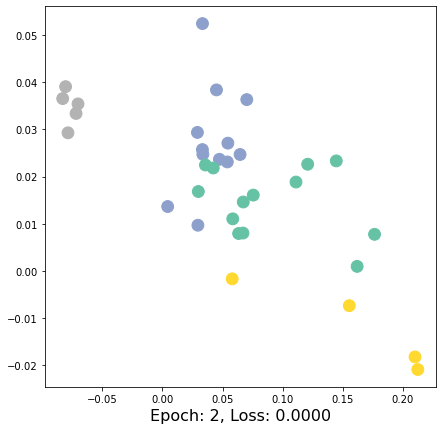

In [20]:
_, embeddings = model(g.x, g.edge_index)
visualize_embedding(embeddings, color=g.y, loss=torch.tensor([0]), epoch=2)

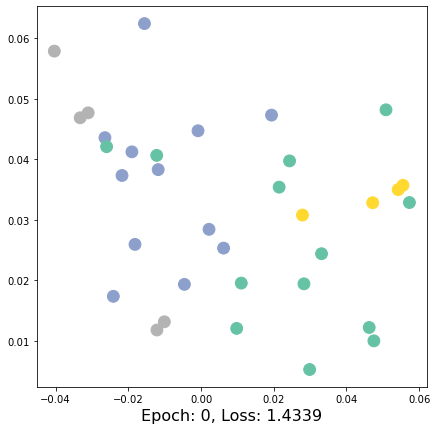

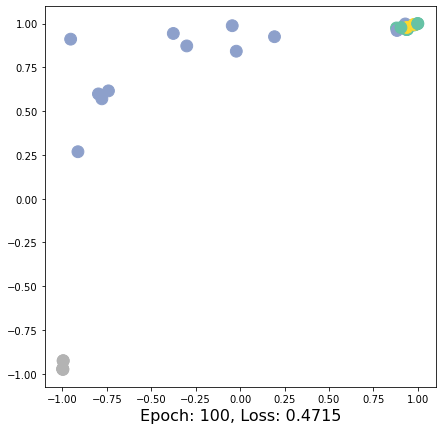

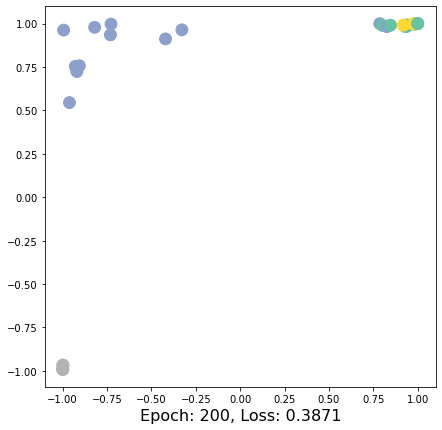

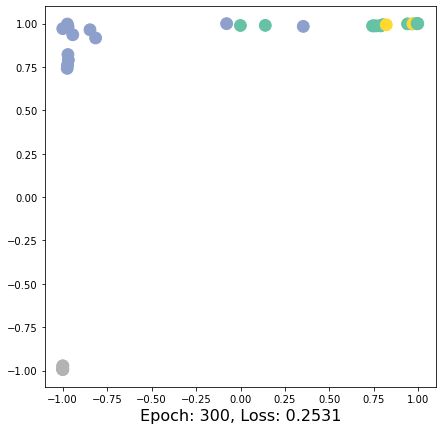

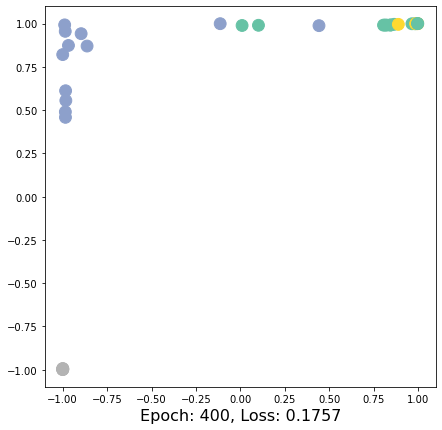

In [24]:
model = GCN(
    n_input=dataset.num_features, 
    n_hidden_layers=3, 
    n_hidden=4,
    n_out=2, 
    n_classes=dataset.num_classes, 
    activation=torch.tanh,
    dropout_p=0
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.01)

for epoch in range(401):
    logits, embeddings = model(g.x, g.edge_index)
    loss = criterion(logits[g.train_mask], g.y[g.train_mask])
    loss.backward()  
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 100 == 0:
        visualize_embedding(embeddings, color=g.y, epoch=epoch, loss=loss)